In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split
import kagglehub as kh
from sklearn.metrics import confusion_matrix

NORMALIZE_COUNTS = True

/home/zato-1/.venv/music/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kh.dataset_download("uciml/msd-audio-features")
print("Path to dataset files:", path)
data_by_decade = pd.read_csv(path + "/year_prediction.csv")
# data_by_ear doesn't have the year labels squashed into decades
data_by_year = pd.read_csv(path + "/year_prediction.csv")

# check for NA
data_dropped = data_by_decade.dropna()
if len(data_dropped) == len(data_by_decade):
    print("No NA")

def convert_year(year):
    year_str = str(int(year["label"]))
    year_str = year_str[:-1] + '0'
    year_str += 's'
    return year_str

data_by_decade["label"] = data_by_decade.apply(convert_year, axis=1)

labels_trim = data_by_decade["label"]
labels_trim = labels_trim.replace({"2010s": "2000s"})
labels_trim = labels_trim.replace({"2000s": "2000s"})
labels_trim = labels_trim.replace({"1990s": "1990s"})
labels_trim = labels_trim.replace({"1980s": "1980s"})
labels_trim = labels_trim.replace({"1970s": "1970s"})
labels_trim = labels_trim.replace({"1960s": "<=1960s"})
labels_trim = labels_trim.replace({"1950s":  "<=1960s"})
labels_trim = labels_trim.replace({"1940s": "<=1960s"})
labels_trim = labels_trim.replace({"1930s":  "<=1960s"})
labels_trim = labels_trim.replace({"1920s":  "<=1960s"})
data_by_decade["label"] = labels_trim

data_by_decade, test_big = train_test_split(data_by_decade, train_size=0.7, random_state=42, stratify=data_by_decade["label"])

if NORMALIZE_COUNTS:
    min_count = data_by_decade['label'].value_counts().min()
    data_by_decade = data_by_decade.groupby('label').apply(lambda x: x.sample(min_count, replace=True)).reset_index(drop=True)

X = data_by_decade.drop(columns=[ "label"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
data_by_decade = pd.concat([pd.DataFrame(data_by_decade["label"]), pd.DataFrame(X_scaled, columns=X.columns)], axis=1)

data_by_decade["label"].value_counts()

Path to dataset files: /home/zato-1/.cache/kagglehub/datasets/uciml/msd-audio-features/versions/1
No NA


/tmp/ipykernel_8473/1641541845.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_by_decade = data_by_decade.groupby('label').apply(lambda x: x.sample(min_count, replace=True)).reset_index(drop=True)


label
1970s      10971
1980s      10971
1990s      10971
2000s      10971
<=1960s    10971
Name: count, dtype: int64

In [3]:
from sklearn.metrics import r2_score

def adjr2(pred, test, p):
    r2 = r2_score(test, pred)
    n = len(test)
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [4]:
avg_cols = [f'TimbreAvg{i}' for i in range(1, 13)]
cov_cols = [f'TimbreCovariance{i}' for i in range(1, 79)]
feature_cols = avg_cols + cov_cols

data_by_decade["label"] = data_by_decade["label"].astype("category")
label_lookup = dict(enumerate(data_by_decade['label'].cat.categories))
train, test = train_test_split(data_by_decade, train_size=0.7, random_state=42, stratify=data_by_decade["label"])
test_lookup = dict(enumerate(test['label'].cat.categories))
train_lookup = dict(enumerate(train['label'].cat.categories))
train["label"] = train["label"].cat.codes
test["label"] = test["label"].cat.codes
assert test_lookup == train_lookup
assert test_lookup == label_lookup

test_label = test["label"].astype("category").cat.codes
train_label = train["label"].astype("category").cat.codes
test.drop("label", axis=1, inplace=True)
train.drop("label", axis=1, inplace=True)

og_cat_test = test.copy()
og_cat_test_label = test_label.copy()

### CatBoost Training (full)

Learning rate set to 0.13661
0:	learn: 1.5764237	total: 27.3ms	remaining: 27.2s
1:	learn: 1.5500366	total: 35.8ms	remaining: 17.9s
2:	learn: 1.5292015	total: 42.4ms	remaining: 14.1s
3:	learn: 1.5102688	total: 50.5ms	remaining: 12.6s
4:	learn: 1.4947231	total: 57.3ms	remaining: 11.4s
5:	learn: 1.4798932	total: 65.1ms	remaining: 10.8s
6:	learn: 1.4678313	total: 72.2ms	remaining: 10.2s
7:	learn: 1.4556671	total: 79.5ms	remaining: 9.86s
8:	learn: 1.4454274	total: 86.8ms	remaining: 9.56s
9:	learn: 1.4363018	total: 93.9ms	remaining: 9.29s
10:	learn: 1.4263243	total: 101ms	remaining: 9.13s
11:	learn: 1.4188155	total: 108ms	remaining: 8.93s
12:	learn: 1.4104889	total: 117ms	remaining: 8.88s
13:	learn: 1.4036688	total: 124ms	remaining: 8.71s
14:	learn: 1.3960449	total: 132ms	remaining: 8.69s
15:	learn: 1.3893551	total: 139ms	remaining: 8.57s
16:	learn: 1.3832833	total: 149ms	remaining: 8.59s
17:	learn: 1.3775762	total: 155ms	remaining: 8.47s
18:	learn: 1.3713594	total: 164ms	remaining: 8.46s
19

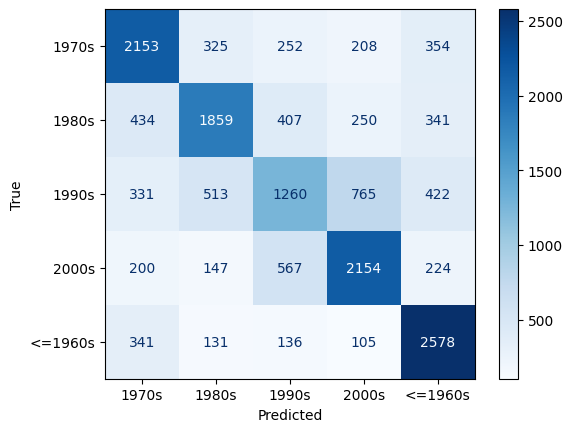

In [6]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

# CATBOOST ACCURACY
pred = cat_model.predict(test)
test_label_list = test_label.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
print(adjr2(test_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### Multinom Training (full)

/home/zato-1/.venv/music/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.5007595552044722
0.19969481155457058


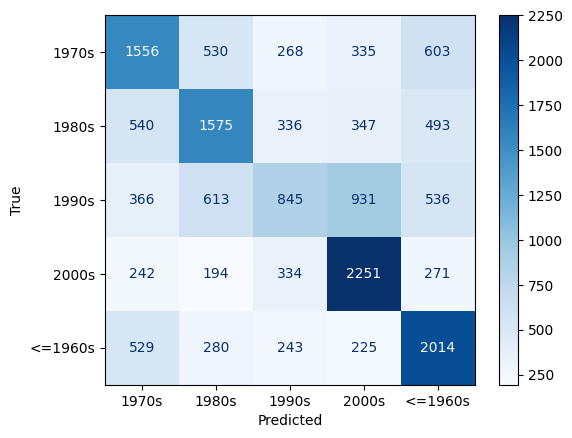

In [7]:
multinomial_model = LogisticRegression(multi_class='multinomial')
multi_res = multinomial_model.fit(train, train_label)

# MULTINOMIAL ACCURACY
multi_preds = multi_res.predict(test)

correct = 0
for i, label in enumerate(test_label):
    if label == multi_preds[i]:
        correct += 1

acc = correct / len(test_label)
print(acc)
print(adjr2(test_label, pred, len(train.columns) - 1))
# confusion matrix
matrix = confusion_matrix(test_label, multi_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### Multinom Reduced

In [8]:
# sample down
df_sample = data_by_decade
if len (data_by_decade) > 100000:
    df_sample =  train_test_split(data_by_decade, train_size=(100000 / len(data_by_decade)), random_state=42, stratify=data_by_decade["label"])
else:
    df_sample =  train_test_split(data_by_decade, train_size=(10000 / len(data_by_decade)), random_state=42, stratify=data_by_decade["label"])
df_sample = pd.DataFrame(df_sample[0], columns=data_by_decade.columns)

sample_train, sample_test = train_test_split(df_sample, train_size=0.7, random_state=42, stratify=df_sample["label"])

sample_test_label = sample_test["label"].astype("category").cat.codes
sample_train_label = sample_train["label"].astype("category").cat.codes
sample_test.drop("label", axis=1, inplace=True)
sample_train.drop("label", axis=1, inplace=True)


In [9]:
# ___________Find Best Alpha___________
param_grid = {'alpha': np.linspace(0.01, 1, 25)} 
grid_search = GridSearchCV(Lasso(), param_grid, cv=5)
grid_search.fit(sample_train, sample_train_label)

# Get the best parameters and best score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

# Fit the model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(sample_train, sample_train_label)

# Evaluate the performance on the test set
test_score = lasso_best.score(sample_test, sample_test_label)

print(f"Best alpha from GridSearchCV: {best_alpha}")
print(f"Best cross-validation score: {best_score}")
print(f"Test R^2 score: {test_score}")


# ___________Apply Best Alpha___________

lasso = Lasso(alpha=best_alpha, random_state=1)
lasso.fit(sample_train, sample_train_label)

coef = pd.Series(lasso.coef_, index=feature_cols)
selected_features = coef[coef != 0]

# Sort by the absolute value but retain the original sign
sorted_by_abs_value = selected_features.reindex(selected_features.abs().sort_values(ascending=False).index)

num_features = len(sorted_by_abs_value)
print(f"\n{num_features} Selected Features by LASSO (sorted by absolute value):")
print(sorted_by_abs_value)


Best alpha from GridSearchCV: 0.01
Best cross-validation score: 0.10970681758177403
Test R^2 score: 0.10377607271403966

65 Selected Features by LASSO (sorted by absolute value):
TimbreAvg1            0.282746
TimbreAvg2           -0.273741
TimbreAvg11          -0.200912
TimbreAvg7           -0.101420
TimbreCovariance46    0.095739
                        ...   
TimbreCovariance74   -0.004300
TimbreCovariance77   -0.002949
TimbreCovariance20    0.002157
TimbreCovariance72    0.000917
TimbreCovariance55   -0.000612
Length: 65, dtype: float64


In [10]:
reduced_features = sorted_by_abs_value.index.to_list()
data_by_decade_reduced = data_by_decade.drop(columns=reduced_features)


train_reduced, test_reduced = train_test_split(data_by_decade_reduced, train_size=0.7, random_state=42, stratify=data_by_decade_reduced["label"])

test_reduced_label = test_reduced["label"].astype("category").cat.codes
train_reduced_label = train_reduced["label"].astype("category").cat.codes
test_reduced.drop("label", axis=1, inplace=True)
train_reduced.drop("label", axis=1, inplace=True)

/home/zato-1/.venv/music/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.19969481155457058


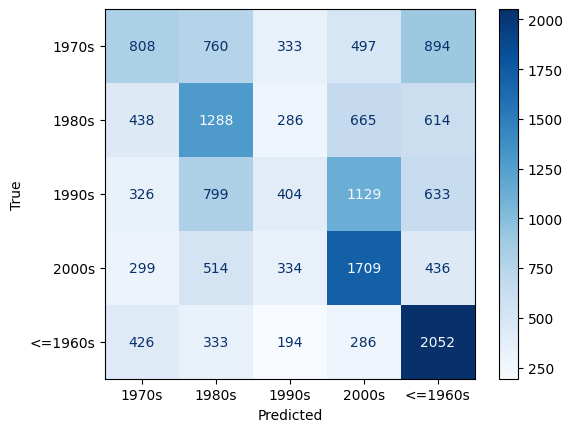

In [11]:
multinomial_model = LogisticRegression(multi_class='multinomial')
multi_res = multinomial_model.fit(train_reduced, train_reduced_label)

# MULTINOMIAL ACCURACY
multi_preds = multi_res.predict(test_reduced)

correct = 0
for i, label in enumerate(test_reduced_label):
    if label == multi_preds[i]:
        correct += 1

correct / len(test_label)
print(adjr2(test_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_reduced_label, multi_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### CatBoost Reduced

In [12]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

Learning rate set to 0.13661
0:	learn: 1.5764235	total: 6.45ms	remaining: 6.44s
1:	learn: 1.5500365	total: 13.2ms	remaining: 6.61s
2:	learn: 1.5292014	total: 19.1ms	remaining: 6.36s
3:	learn: 1.5102691	total: 24.8ms	remaining: 6.18s
4:	learn: 1.4947231	total: 31.7ms	remaining: 6.31s
5:	learn: 1.4798932	total: 37.5ms	remaining: 6.22s
6:	learn: 1.4678316	total: 43.4ms	remaining: 6.16s
7:	learn: 1.4556673	total: 50.9ms	remaining: 6.31s
8:	learn: 1.4454275	total: 56.6ms	remaining: 6.23s
9:	learn: 1.4363017	total: 64.1ms	remaining: 6.35s
10:	learn: 1.4263246	total: 70.2ms	remaining: 6.32s
11:	learn: 1.4188151	total: 76ms	remaining: 6.26s
12:	learn: 1.4104885	total: 83.7ms	remaining: 6.35s
13:	learn: 1.4036690	total: 89.7ms	remaining: 6.32s
14:	learn: 1.3960448	total: 97ms	remaining: 6.37s
15:	learn: 1.3893552	total: 103ms	remaining: 6.33s
16:	learn: 1.3832831	total: 109ms	remaining: 6.3s
17:	learn: 1.3775762	total: 117ms	remaining: 6.36s
18:	learn: 1.3713595	total: 122ms	remaining: 6.32s
19

In [13]:
cat_res.feature_names_
cat_res.feature_importances_
sorted_importances = sorted(zip(cat_res.feature_names_, cat_res.feature_importances_), key=lambda x: x[1], reverse=True)
sorted_importances

top = sorted_importances[:70]
top_names = [x[0] for x in top]

top_names
remaining_names = [x for x in cat_res.feature_names_ if x not in top_names]
remaining_names

['TimbreCovariance6',
 'TimbreCovariance18',
 'TimbreCovariance19',
 'TimbreCovariance21',
 'TimbreCovariance22',
 'TimbreCovariance23',
 'TimbreCovariance30',
 'TimbreCovariance39',
 'TimbreCovariance41',
 'TimbreCovariance42',
 'TimbreCovariance50',
 'TimbreCovariance52',
 'TimbreCovariance54',
 'TimbreCovariance57',
 'TimbreCovariance63',
 'TimbreCovariance65',
 'TimbreCovariance72',
 'TimbreCovariance74',
 'TimbreCovariance75',
 'TimbreCovariance77']

In [14]:
data_by_decade_reduced_by_importance = data_by_decade.drop(columns=remaining_names)


train_reduced_by_importance, test_reduced_by_importance = train_test_split(data_by_decade_reduced_by_importance, train_size=0.7, random_state=42, stratify=data_by_decade_reduced_by_importance["label"])

test_reduced_by_importance_label = test_reduced_by_importance["label"].astype("category").cat.codes
train_reduced_by_importance_label = train_reduced_by_importance["label"].astype("category").cat.codes
test_reduced_by_importance.drop("label", axis=1, inplace=True)
train_reduced_by_importance.drop("label", axis=1, inplace=True)

Learning rate set to 0.13661
0:	learn: 1.5764234	total: 4.95ms	remaining: 4.95s
1:	learn: 1.5500365	total: 10.2ms	remaining: 5.1s
2:	learn: 1.5292015	total: 14.5ms	remaining: 4.82s
3:	learn: 1.5102691	total: 18.9ms	remaining: 4.71s
4:	learn: 1.4947229	total: 24.2ms	remaining: 4.82s
5:	learn: 1.4798930	total: 28.5ms	remaining: 4.72s
6:	learn: 1.4678316	total: 32.8ms	remaining: 4.65s
7:	learn: 1.4556672	total: 37.2ms	remaining: 4.61s
8:	learn: 1.4454275	total: 42.5ms	remaining: 4.68s
9:	learn: 1.4363017	total: 46.6ms	remaining: 4.62s
10:	learn: 1.4263245	total: 51.1ms	remaining: 4.59s
11:	learn: 1.4188155	total: 55.8ms	remaining: 4.6s
12:	learn: 1.4104887	total: 60.4ms	remaining: 4.58s
13:	learn: 1.4036688	total: 64.6ms	remaining: 4.55s
14:	learn: 1.3960450	total: 69.2ms	remaining: 4.54s
15:	learn: 1.3893549	total: 74.5ms	remaining: 4.58s
16:	learn: 1.3832835	total: 78.7ms	remaining: 4.55s
17:	learn: 1.3775761	total: 83.1ms	remaining: 4.53s
18:	learn: 1.3713597	total: 87.4ms	remaining: 4

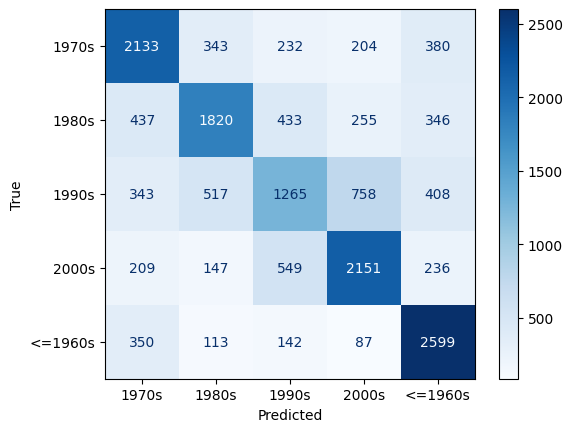

In [15]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train_reduced_by_importance, train_reduced_by_importance_label) 

pred = cat_model.predict(test_reduced_by_importance)
test_label_list = test_reduced_by_importance_label.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
#print(adjr2(train_reduced_by_importance, pred, len(train_reduced_by_importance.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_reduced_by_importance_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

0.5962976378360197


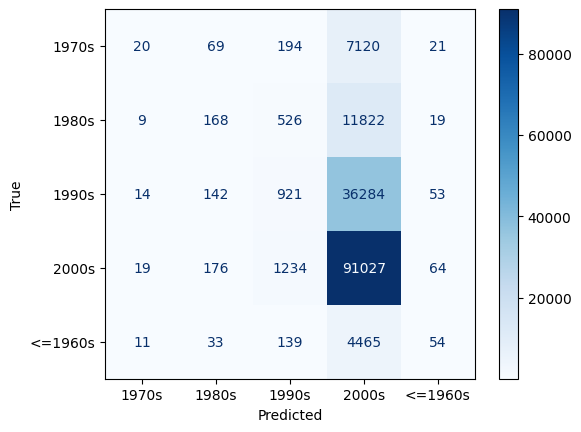

In [16]:
test_big_label = test_big["label"].astype("category").cat.codes
test_big.drop("label", axis=1, inplace=True)

pred = cat_model.predict(test_big)
test_label_list = test_big_label.tolist()
num_right = 0
#
for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
#print(adjr2(test_big_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_big_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()